In this notebook we plot some data regarding matching times and memory usage of different versions of the Java regular expression matcher and our own modified version of the OpenJDK source code. Additionally, we compare different selective memoization policies with respect to state size and execution time. 

In [14]:
import json
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from pathlib import Path
from typing import List, Dict

In [2]:
DATA_DIR = Path(os.path.abspath('') + '/data').resolve()
assert DATA_DIR.is_dir()

def read_data(data_file: Path):
    assert data_file.is_file()
    with open(data_file, 'r') as f:
        return json.load(f)

## RegExLib dataset

In [3]:
REGEXLIB_SESS = Path('{}/regexlib'.format(DATA_DIR))
regexlib_analysis = read_data(Path('{}/simple_analysis.json'.format(REGEXLIB_SESS)))

## Polyglot corpus

In [4]:
POLYGLOT_SESS = Path('{}/polyglot'.format(DATA_DIR))
polyglot_analysis = read_data(Path('{}/simple_analysis.json'.format(POLYGLOT_SESS)))

In [5]:
labels = ['Parsing Failures', 'Linear', 'EDA', 'IDA', 'Analysis Failures', 'Analysis Timeouts']

def sizes(obj):
    tk = 'num_simple_analysis_timeout'
    return [
        np.int(obj['num_parsing_failures']),
        np.int(obj['num_cases_linear']),
        np.int(obj['num_cases_eda']),
        np.int(obj['num_cases_ida']),
        np.int(obj['num_simple_analysis_failures']),
        np.int(obj[tk]) if tk in obj else 0
    ]

def percentage(size, count):
    return (float(size) / float(count)) * 100

def print_table(sizes, labels, dataset):
    print('-- {} --'.format(dataset))
    count = sum(sizes)
    ml = len(max(labels, key=len))
    for i, el in enumerate(labels):
        print('{}: {}/{} ({:.2f}%)'.format(el.ljust(ml), sizes[i], count, percentage(sizes[i], count)))
    print()

The tables below tell us how well the simple analysis dealt with the regexes in both the RegExLib and Polyglot datasets. We look at how many regexes are safe and how many contain EDA or IDA.

In [6]:
print_table(sizes(regexlib_analysis), labels, 'RegExLib')
print_table(sizes(polyglot_analysis), labels, 'Polyglot Corpus')

-- RegExLib --
Parsing Failures : 480/2981 (16.10%)
Linear           : 1508/2981 (50.59%)
EDA              : 105/2981 (3.52%)
IDA              : 0/2981 (0.00%)
Analysis Failures: 888/2981 (29.79%)
Analysis Timeouts: 0/2981 (0.00%)

-- Polyglot Corpus --
Parsing Failures : 70386/534958 (13.16%)
Linear           : 376592/534958 (70.40%)
EDA              : 2591/534958 (0.48%)
IDA              : 0/534958 (0.00%)
Analysis Failures: 84333/534958 (15.76%)
Analysis Timeouts: 1056/534958 (0.20%)



In [7]:
def boxplot(ax, data, xlabels, title, xlabel, ylabel, yscale='linear', showfliers=True):
    # Creating plot 
    ax.boxplot(data, showfliers=showfliers) 
    
    ax.set_xticks(np.arange(1, len(xlabels)+1))
    ax.set_xticklabels(xlabels)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale(yscale)
    ax.set_title(title)

def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, ['{}'.format(k) for k in data.keys()])

### Node Size and Execution Time of Memoization Schemes

Below we look at the distribution of the node size of the different memoisation schemes. Additionally, we look at the execution time of determining which nodes to memoize. 

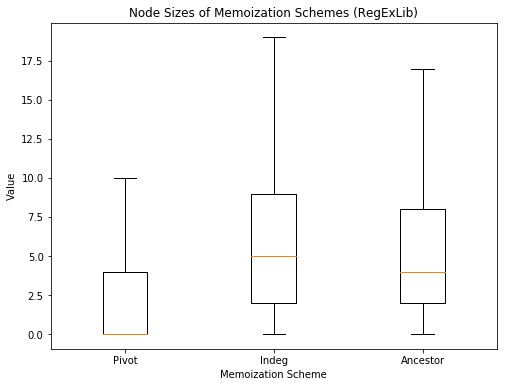

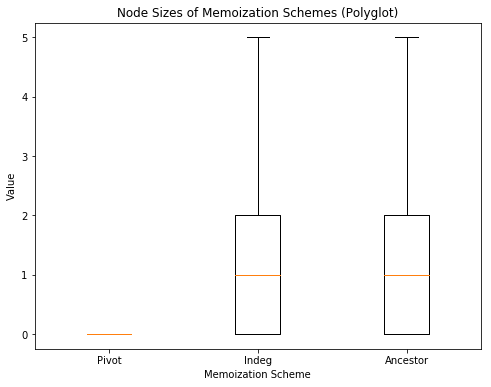

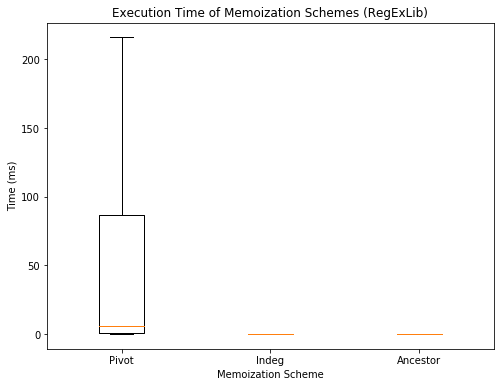

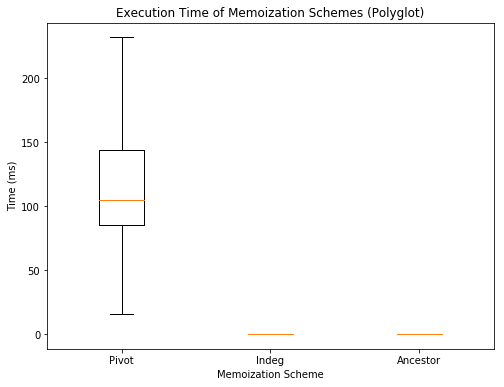

In [8]:
MemoizationScheme = namedtuple('MemoizationScheme', 'pivot indeg ancestor')

def get_data_per_pattern(patterns, key):
    result = MemoizationScheme([], [], [])
    for p in patterns:
        result.pivot.append(p['pivot'][key])
        result.indeg.append(p['indeg'][key])
        result.ancestor.append(p['ancestor'][key])
    return result

rns = get_data_per_pattern(regexlib_analysis['patterns'], 'num_states')
pns = get_data_per_pattern(polyglot_analysis['patterns'], 'num_states')

labels = ['Pivot', 'Indeg', 'Ancestor']
fig, ax = plt.subplots(figsize=(8,6))
boxplot(ax, [rns.pivot, rns.indeg, rns.ancestor], labels, 'Node Sizes of Memoization Schemes (RegExLib)', 'Memoization Scheme', 'Value', yscale='linear', showfliers=False)
fig, ax = plt.subplots(figsize=(8,6))
boxplot(ax, [pns.pivot, pns.indeg, pns.ancestor], labels, 'Node Sizes of Memoization Schemes (Polyglot)', 'Memoization Scheme', 'Value', yscale='linear', showfliers=False)

ret = get_data_per_pattern(regexlib_analysis['patterns'], 'exec_time')
pet = get_data_per_pattern(polyglot_analysis['patterns'], 'exec_time')

labels = ['Pivot', 'Indeg', 'Ancestor']
fig, ax = plt.subplots(figsize=(8,6))
boxplot(ax, [ret.pivot, ret.indeg, ret.ancestor], labels, 'Execution Time of Memoization Schemes (RegExLib)', 'Memoization Scheme', 'Time (ms)', yscale='linear', showfliers=False)
fig, ax = plt.subplots(figsize=(8,6))
boxplot(ax, [pet.pivot, pet.indeg, pet.ancestor], labels, 'Execution Time of Memoization Schemes (Polyglot)', 'Memoization Scheme', 'Time (ms)', yscale='linear', showfliers=False)

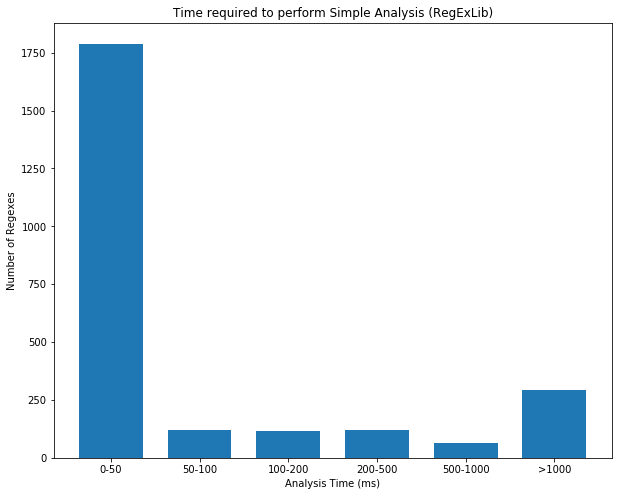

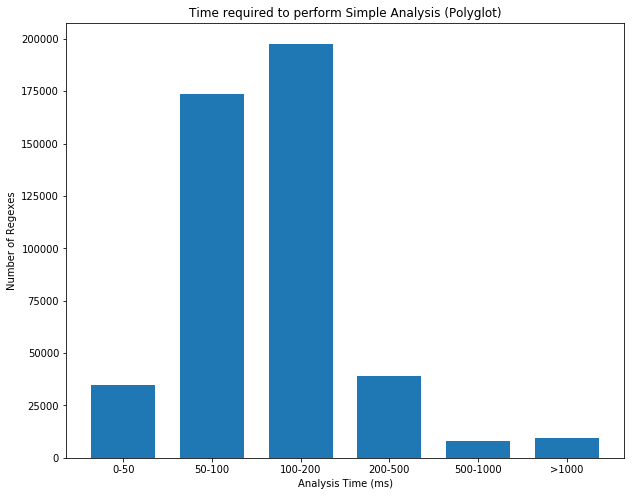

In [9]:
labels = ['0-50', '50-100', '100-200', '200-500', '500-1000', '>1000']

def make_classes(data):
    return [
        len(list(filter(lambda x: x <= 50, data))),
        len(list(filter(lambda x: x > 50 and x <= 100, data))),
        len(list(filter(lambda x: x > 100 and x <= 200, data))),
        len(list(filter(lambda x: x > 200 and x <= 500, data))),
        len(list(filter(lambda x: x > 500 and x <= 1000, data))),
        len(list(filter(lambda x: x > 1000, data)))
    ]

def sa_plot(data, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    bar_plot(ax, {'Simple Analysis': make_classes(data)}, total_width=.8, single_width=.9, legend=False)

    ax.set_xlabel('Analysis Time (ms)')
    ax.set_ylabel('Number of Regexes')
    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)

    plt.show()

sa_plot(ret.pivot, 'Time required to perform Simple Analysis (RegExLib)')
sa_plot(pet.pivot, 'Time required to perform Simple Analysis (Polyglot)')

## OpenJDK benchmarks
Below we look at the matching times of the Java regular expression matcher.

In [10]:
regexlib_jb = read_data(Path('{}/java_benchmarks.json'.format(REGEXLIB_SESS)))
polyglot_jb = read_data(Path('{}/java_benchmarks.json'.format(POLYGLOT_SESS)))

JDKVersions = namedtuple('JDKVersions', 'm_8 m_9 m_11 m_11_modified')

def get_matching_times(dataset):
    result = JDKVersions([], [], [], [])
    result.m_11_modified.extend(list(map(lambda x: x['time'], dataset[0]['11-modified'])))
    result.m_11.extend(list(map(lambda x: x['time'], dataset[1]['11'])))
    result.m_9.extend(list(map(lambda x: x['time'], dataset[2]['9'])))
    result.m_8.extend(list(map(lambda x: x['time'], dataset[3]['8'])))
    return result

regexlib_mt = get_matching_times(regexlib_jb)
polyglot_mt = get_matching_times(polyglot_jb)

def print_ratios(jdk_versions, dataset_name):
    print('-- {} --'.format(dataset_name))
    
    def counts(data, version):
        count = len(data)
        c = sum(t == '0' for t in data)
        print('{} 0ms: {}/{} ({:.2f}%)'.format(version, c, count, percentage(c, count)))
        c = sum(t.isdigit() and np.int(t) > 0 for t in data)
        print('{} >0ms: {}/{} ({:.2f}%)'.format(version, c, count, percentage(c, count)))
        c = sum(t == 'timeout' for t in data)
        print('{} TIMEOUT: {}/{} ({:.2f}%)'.format(version, c, count, percentage(c, count)))
        print('===')
    
    counts(jdk_versions.m_8, 'JDK8')
    counts(jdk_versions.m_9, 'JDK9')
    counts(jdk_versions.m_11, 'JDK11')
    counts(jdk_versions.m_11_modified, 'JDK11-modified')
    print()

print_ratios(regexlib_mt, 'RegExLib')
print_ratios(polyglot_mt, 'Polyglot Corpus')

-- RegExLib --
JDK8 0ms: 866/962 (90.02%)
JDK8 >0ms: 4/962 (0.42%)
JDK8 TIMEOUT: 92/962 (9.56%)
===
JDK9 0ms: 918/962 (95.43%)
JDK9 >0ms: 29/962 (3.01%)
JDK9 TIMEOUT: 15/962 (1.56%)
===
JDK11 0ms: 918/962 (95.43%)
JDK11 >0ms: 29/962 (3.01%)
JDK11 TIMEOUT: 15/962 (1.56%)
===
JDK11-modified 0ms: 923/962 (95.95%)
JDK11-modified >0ms: 37/962 (3.85%)
JDK11-modified TIMEOUT: 2/962 (0.21%)
===

-- Polyglot Corpus --
JDK8 0ms: 1337/2554 (52.35%)
JDK8 >0ms: 11/2554 (0.43%)
JDK8 TIMEOUT: 1206/2554 (47.22%)
===
JDK9 0ms: 2245/2554 (87.90%)
JDK9 >0ms: 158/2554 (6.19%)
JDK9 TIMEOUT: 151/2554 (5.91%)
===
JDK11 0ms: 2249/2554 (88.06%)
JDK11 >0ms: 154/2554 (6.03%)
JDK11 TIMEOUT: 151/2554 (5.91%)
===
JDK11-modified 0ms: 2328/2554 (91.15%)
JDK11-modified >0ms: 131/2554 (5.13%)
JDK11-modified TIMEOUT: 95/2554 (3.72%)
===



### Transform Java Matching Times

For the box plots we filter out 0ms matching times because it skews the data. We plot the y-axes at a linear and log scale.

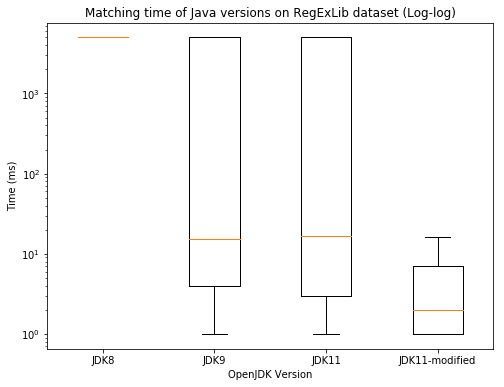

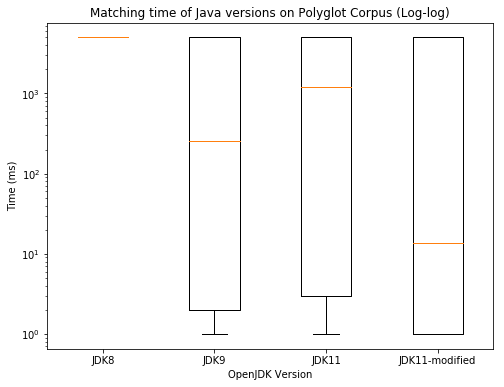

In [11]:
def transform(data):
    func1 = lambda x: '5000' if x == 'timeout' else x
    func2 = lambda x: x != '0'
    return JDKVersions(
        list(map(int, filter(func2, map(func1, data.m_8)))),
        list(map(int, filter(func2, map(func1, data.m_9)))),
        list(map(int, filter(func2, map(func1, data.m_11)))),
        list(map(int, filter(func2, map(func1, data.m_11_modified)))),
    )

regexlib_mt = transform(regexlib_mt)
polyglot_mt = transform(polyglot_mt)

labels = ['JDK8', 'JDK9', 'JDK11', 'JDK11-modified']
fig, ax = plt.subplots(figsize=(8, 6))
boxplot(ax, [regexlib_mt.m_8, regexlib_mt.m_9, regexlib_mt.m_11, regexlib_mt.m_11_modified], labels, 'Matching time of Java versions on RegExLib dataset (Log-log)', 'OpenJDK Version', 'Time (ms)', yscale='log', showfliers=False)
fig, ax = plt.subplots(figsize=(8, 6))
boxplot(ax, [polyglot_mt.m_8, polyglot_mt.m_9, polyglot_mt.m_11, polyglot_mt.m_11_modified], labels, 'Matching time of Java versions on Polyglot Corpus (Log-log)', 'OpenJDK Version', 'Time (ms)', yscale='log', showfliers=False)

## On which regexes do all JDK versions time out?

In [34]:
def get_intersecting_regexes(data):
    def get_timeouts(data):
        return list(filter(lambda x: x['time'] == 'timeout', data))
    
    result = []
    m11_mod = get_timeouts(data[0]['11-modified'])
    m11 = get_timeouts(data[1]['11'])
    m9 = get_timeouts(data[2]['9'])
    m8 = get_timeouts(data[3]['8'])
    for e in m11_mod + m11 + m9 + m8:
           if (e not in result) and (e in m11_mod and e in m11 and e in m9 and e in m8):
                result.append(e)
    return result

def print_intersec(data, name):
    def shorten_exploit(exploit):
        l = len(exploit)
        return '{}...{}'.format(exploit[0:8], exploit[l-8:])
    
    print('-- {} --'.format(name))
    for e in data:
        print('{} [exploit=\'{}\']'.format(e['pattern'], shorten_exploit(e['exploit'])))
    print()
    
print_intersec(get_intersecting_regexes(regexlib_jb), 'RegExLib')
print_intersec(get_intersecting_regexes(polyglot_jb), 'Polyglot')

-- RegExLib --
<(?:[^"']+?|.+?(?:"|').*?(?:"|')?.*?)*?> [exploit='<aaaaaaa...aaaaaaa<']
((?:[^",]|(?:"(?:\\{2}|\\"|[^"])*?"))*) [exploit='"\\\\"\"...\"\"\,",']

-- Polyglot --
^(\"((?:\\\\|\\\"|.)+?)\") [exploit='"a\"\"\"...\"\"\"\a']
^(?:<!--.*?-->\s*?)*?<([a-z]+)[\s>] [exploit='<!---->\...<!---->-']
"(\\.|.)*?" [exploit='"\\a\\a\...\\a\\a\a']
^\[\^((?:[^\]]|\]|\[)+?)\]: [exploit='[^][[[[[...[[[[[[[]']
\^{3}math(.*?\n*?)+?\^{3} [exploit='^^^matha...amat\x0a']
^"(?:\\"|.)*?"$ [exploit='"\"\"\"\...\"\"\"\a']
(\*?[-#\/\*\\\w]+(?:\[[0-9a-z_-]+\])?)\s*:\s*(?:\'(?:\\\'|.)*?\'|"(?:\\"|.)*?"|\([^\)]*?\)|[^};])+[;\s]* [exploit='*a:'\'\'...\'a\x09}']
\/(?:(?:\\.|[^\/\r\n])+?)\/ [exploit='/\a\a\a\...\a\/\x0a']
^E(?:\\'|.)*?'$ [exploit='E\'\'\'\...'\'\'\'a']
\?|\*|\{((?:\{[^/]+?\}|[^/{}]|\\[{}])+?)\} [exploit='{{a}\{{a...}\{{a*a{']
^\s*\[\s*'((?:\\'|.)*?)'\s*\] [exploit='['a\'a\'...'a\'a\'[']
'(?:\\?[\s\S])*?' [exploit=''\\a\\a\...a\\a\\aa']
^\(*"((.|\\|\")*?)" * [exploit='""""""""..."""""""\']
^